# DVM
Pre-proceed DVM data and create train/val/test datasets
* Tabular data (.csv)
* Image paths (.pt)
* Labels (.pt)
* Tabular lengths (.pt): record the number of unique values for each column

Based on MMCL code https://github.com/paulhager/MMCL-Tabular-Imaging/blob/main/data/create_dvm_dataset.ipynb

In [1]:
import pandas as pd
import os
from os.path import join
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchvision.io import read_image
from matplotlib import pyplot as plt
import torchvision
import torch
import random
import numpy as np
from sklearn.neighbors import NearestNeighbors

pd.options.display.max_columns = 700

# TODO: change this to the path of your DVM data directory
BASE = '/bigdata/siyi/data/DVM'
TABLES = join(BASE, 'tables_V2.0')
FEATURES = join(BASE, 'features') 

front_view_only = False

from typing import List
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import k_means, SpectralClustering
import multiprocessing as mp

ANALYSIS = join(BASE, 'analysis')

def conf_matrix_from_matrices(mat_gt, mat_pred):
  overlap_and = (mat_pred & mat_gt)
  tp = overlap_and.sum()
  fp = mat_pred.sum()-overlap_and.sum()
  fn = mat_gt.sum()-overlap_and.sum()
  tn = mat_gt.shape[0]**2-(tp+fp+fn)
  return tp, fp, fn, tn

/home/siyi/miniconda3/envs/selfsuper/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def check_or_save(obj, path, index=None, header=None):
  if isinstance(obj, pd.DataFrame):
    if index is None or header is None:
      raise ValueError('Index and header must be specified for saving a dataframe')
    if os.path.exists(path):
      if not header:
        saved_df = pd.read_csv(path,header=None)
      else:
        saved_df = pd.read_csv(path)
      naked_df = saved_df.reset_index(drop=True)
      naked_df.columns = range(naked_df.shape[1])
      naked_obj = obj.reset_index(drop=not index)
      naked_obj.columns = range(naked_obj.shape[1])
      if naked_df.round(6).equals(naked_obj.round(6)):
        return
      else:
        diff = (naked_df.round(6) == naked_obj.round(6))
        diff[naked_df.isnull()] = naked_df.isnull() & naked_obj.isnull()
        assert diff.all().all(), "Dataframe is not the same as saved dataframe"
    else:
      obj.to_csv(path, index=index, header=header)
  else:
    if os.path.exists(path):
      saved_obj = torch.load(path)
      if isinstance(obj, list):
        for i in range(len(obj)):
          check_array_equality(obj[i], saved_obj[i])
      else:
        check_array_equality(obj, saved_obj)
    else:
      print(f'Saving to {path}')
      torch.save(obj, path)


def check_array_equality(ob1, ob2):
  if torch.is_tensor(ob1) or isinstance(ob1, np.ndarray):
    assert (ob2 == ob1).all()
  else:
    assert ob2 == ob1

# Create Tabular Dataset

In [3]:
ad_data = pd.read_csv(join(TABLES, 'Ad_table.csv'))
ad_data.rename(columns={' Genmodel': 'Genmodel', ' Genmodel_ID': 'Genmodel_ID'}, inplace=True)

basic_data = pd.read_csv(join(TABLES, 'Basic_table.csv'))

image_data = pd.read_csv(join(TABLES, 'Image_table.csv'))
image_data.rename(columns={' Image_ID': 'Image_ID', ' Image_name': 'Image_name', ' Predicted_viewpoint':'Predicted_viewpoint', ' Quality_check':'Quality_check'}, inplace=True)

price_data = pd.read_csv(join(TABLES, 'Price_table.csv'))
price_data.rename(columns={' Genmodel': 'Genmodel', ' Genmodel_ID': 'Genmodel_ID', ' Year': 'Year', ' Entry_price': 'Entry_price'}, inplace=True)

sales_data = pd.read_csv(join(TABLES, 'Sales_table.csv'))
sales_data.rename(columns={'Genmodel ': 'Genmodel', 'Genmodel_ID ': 'Genmodel_ID'}, inplace=True)

trim_data = pd.read_csv(join(TABLES, 'Trim_table.csv'))

/tmp/ipykernel_3263482/622457649.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  ad_data = pd.read_csv(join(TABLES, 'Ad_table.csv'))


In [4]:
def parser_adv_id(x):
  split = x["Image_ID"].split('$$')
  return f"{split[0]}$${split[1]}"

image_data["Adv_ID"] = image_data.apply(lambda x: parser_adv_id(x), axis=1)
if front_view_only:
  image_data = image_data[(image_data["Quality_check"]=="P")&(image_data["Predicted_viewpoint"]==0)]
image_data.drop_duplicates(subset=['Adv_ID'], inplace=True)
image_data

,Genmodel_ID,Image_ID,Image_name,Predicted_viewpoint,Quality_check,Adv_ID
0,2_1,2_1$$1$$1,Abarth$$124 Spider$$2017$$Blue$$2_1$$1$$image_...,45,NaN,2_1$$1
1,2_1,2_1$$10$$11,Abarth$$124 Spider$$2017$$Blue$$2_1$$10$$image...,45,NaN,2_1$$10
8,2_1,2_1$$4$$0,Abarth$$124 Spider$$2017$$Blue$$2_1$$4$$image_...,0,P,2_1$$4
14,2_1,2_1$$8$$3,Abarth$$124 Spider$$2017$$Blue$$2_1$$8$$image_...,0,NaN,2_1$$8
18,2_1,2_1$$13$$8,Abarth$$124 Spider$$2017$$Grey$$2_1$$13$$image...,0,P,2_1$$13
...,...,...,...,...,...,...
1451766,96_18,96_18$$919$$3,Volvo$$XC90$$2019$$White$$96_18$$919$$image_3.jpg,225,NaN,96_18$$919
1451771,97_1,97_1$$1$$1,Westfield$$Sport$$2006$$Yellow$$97_1$$1$$image...,45,NaN,97_1$$1
1451772,99_1,99_1$$2$$14,Zenos$$E10$$2016$$Green$$99_1$$2$$image_14.jpg,180,NaN,99_1$$2
1451775,99_1,99_1$$3$$1,Zenos$$E10$$2016$$Grey$$99_1$$3$$image_1.jpg,0,P,99_1$$3


In [5]:
print(len(ad_data))
feature_df = ad_data.merge(price_data[['Genmodel_ID', 'Entry_price', 'Year']], left_on=['Genmodel_ID','Reg_year'], right_on=['Genmodel_ID','Year'])
print(len(feature_df))
feature_df

268255
224724


,Maker,Genmodel,Genmodel_ID,Adv_ID,Adv_year,Adv_month,Color,Reg_year,Bodytype,Runned_Miles,Engin_size,Gearbox,Fuel_type,Price,Seat_num,Door_num,Entry_price,Year
0,Bentley,Arnage,10_1,10_1$$1,2018,4,Silver,2000.0,Saloon,60000,6.8L,Automatic,Petrol,21500,5.0,4.0,145000,2000
1,Bentley,Arnage,10_1,10_1$$13,2018,4,Silver,2000.0,Saloon,53444,6.8L,Automatic,Petrol,21995,5.0,4.0,145000,2000
2,Bentley,Arnage,10_1,10_1$$15,2018,4,Black,2000.0,Saloon,61500,6.7L,Automatic,Petrol,16500,NaN,NaN,145000,2000
3,Bentley,Arnage,10_1,10_1$$16,2017,12,Blue,2000.0,Saloon,49700,4.4L,Automatic,Petrol,29500,5.0,4.0,145000,2000
4,Bentley,Arnage,10_1,10_1$$18,2018,4,White,2000.0,Saloon,75000,6.8L,Automatic,Petrol,17995,5.0,4.0,145000,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224719,Volvo,V50,96_9,96_9$$353,2018,5,Silver,2004.0,Estate,100390,2.4L,Automatic,Petrol,1999,5.0,5.0,17165,2004
224720,Volvo,V50,96_9,96_9$$374,2018,5,Silver,2004.0,Estate,149000,2.0L,Manual,Diesel,1450,5.0,5.0,17165,2004
224721,Volvo,V50,96_9,96_9$$457,2018,5,Grey,2004.0,Estate,98167,2.4L,Automatic,Petrol,3995,5.0,5.0,17165,2004
224722,Volvo,V50,96_9,96_9$$477,2018,2,Grey,2004.0,Estate,152230,1.8L,Manual,Petrol,1495,5.0,5.0,17165,2004


In [6]:
data_df = feature_df.merge(image_data[['Adv_ID', 'Image_name', 'Predicted_viewpoint']], left_on=['Adv_ID'], right_on=['Adv_ID'])
assert data_df["Adv_ID"].is_unique

In [7]:
def extract_engine_size(x):
  return float(x['Engin_size'][:-1])

data_df.dropna(inplace=True)
data_df['Engine_size'] = data_df.apply(lambda x: extract_engine_size(x), axis=1)
data_df.drop(columns=['Engin_size'], inplace=True)
data_df

,Maker,Genmodel,Genmodel_ID,Adv_ID,Adv_year,Adv_month,Color,Reg_year,Bodytype,Runned_Miles,Gearbox,Fuel_type,Price,Seat_num,Door_num,Entry_price,Year,Image_name,Predicted_viewpoint,Engine_size
0,Bentley,Arnage,10_1,10_1$$1,2018,4,Silver,2000.0,Saloon,60000,Automatic,Petrol,21500,5.0,4.0,145000,2000,Bentley$$Arnage$$2000$$Silver$$10_1$$1$$image_...,45,6.8
1,Bentley,Arnage,10_1,10_1$$13,2018,4,Silver,2000.0,Saloon,53444,Automatic,Petrol,21995,5.0,4.0,145000,2000,Bentley$$Arnage$$2000$$Silver$$10_1$$13$$image...,0,6.8
3,Bentley,Arnage,10_1,10_1$$16,2017,12,Blue,2000.0,Saloon,49700,Automatic,Petrol,29500,5.0,4.0,145000,2000,Bentley$$Arnage$$2000$$Blue$$10_1$$16$$image_1...,0,4.4
4,Bentley,Arnage,10_1,10_1$$18,2018,4,White,2000.0,Saloon,75000,Automatic,Petrol,17995,5.0,4.0,145000,2000,Bentley$$Arnage$$2000$$White$$10_1$$18$$image_...,90,6.8
5,Bentley,Arnage,10_1,10_1$$26,2017,5,Silver,2000.0,Saloon,98000,Automatic,Petrol,17945,5.0,4.0,145000,2000,Bentley$$Arnage$$2000$$Silver$$10_1$$26$$image...,225,6.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209030,Volvo,V50,96_9,96_9$$353,2018,5,Silver,2004.0,Estate,100390,Automatic,Petrol,1999,5.0,5.0,17165,2004,Volvo$$V50$$2004$$Silver$$96_9$$353$$image_0.jpg,45,2.4
209031,Volvo,V50,96_9,96_9$$374,2018,5,Silver,2004.0,Estate,149000,Manual,Diesel,1450,5.0,5.0,17165,2004,Volvo$$V50$$2004$$Silver$$96_9$$374$$image_0.jpg,0,2.0
209032,Volvo,V50,96_9,96_9$$457,2018,5,Grey,2004.0,Estate,98167,Automatic,Petrol,3995,5.0,5.0,17165,2004,Volvo$$V50$$2004$$Grey$$96_9$$457$$image_0.jpg,45,2.4
209033,Volvo,V50,96_9,96_9$$477,2018,2,Grey,2004.0,Estate,152230,Manual,Petrol,1495,5.0,5.0,17165,2004,Volvo$$V50$$2004$$Grey$$96_9$$477$$image_0.jpg,315,1.8


In [8]:
id_df = data_df.loc[:,'Adv_ID']
image_name_df = data_df.loc[:,'Image_name']
viewpoint_df = data_df.loc[:,'Predicted_viewpoint']

continuous_df = data_df.loc[:,(
  'Adv_year',
  'Adv_month',
  'Reg_year',
  'Runned_Miles',
  'Price',
  'Seat_num',
  'Door_num',
  'Entry_price', 
  'Engine_size'
  )]

categorical_ids = ['Color',
  'Bodytype',
  'Gearbox',
  'Fuel_type',
  'Genmodel_ID']



categorical_df = data_df.loc[:,categorical_ids]

continuous_df['Runned_Miles'] = pd.to_numeric(continuous_df['Runned_Miles'], errors='coerce')
continuous_df['Price'] = pd.to_numeric(continuous_df['Price'], errors='coerce')

# normalize
continuous_df=(continuous_df-continuous_df.mean())/continuous_df.std()

categorical_df['Color'] = categorical_df['Color'].astype('category')
categorical_df['Bodytype'] = categorical_df['Bodytype'].astype('category')
categorical_df['Gearbox'] = categorical_df['Gearbox'].astype('category')
categorical_df['Fuel_type'] = categorical_df['Fuel_type'].astype('category')
categorical_df['Genmodel_ID'] = categorical_df['Genmodel_ID'].astype('category')

cat_columns = categorical_df.select_dtypes(['category']).columns

categorical_df[cat_columns] = categorical_df[cat_columns].apply(lambda x: x.cat.codes)

data_df = pd.concat([id_df, continuous_df, categorical_df, image_name_df, viewpoint_df], axis=1)
data_df.dropna(inplace=True)

In [9]:
minimum_population = 100
values = (data_df.value_counts(subset=['Genmodel_ID'])>=minimum_population).values
codes = (data_df.value_counts(subset=['Genmodel_ID'])>=minimum_population).index
populated_codes = []
for i, v in enumerate(values):
  if v:
    populated_codes.append(int(codes[i][0]))

In [10]:
len(populated_codes)

286

In [11]:
data_df = data_df[data_df['Genmodel_ID'].isin(populated_codes)]
map = {}
for i,l in enumerate(data_df['Genmodel_ID'].unique()):
  map[l] = i
data_df['Genmodel_ID'] = data_df['Genmodel_ID'].map(map)
data_df

,Adv_ID,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,Door_num,Entry_price,Engine_size,Color,Bodytype,Gearbox,Fuel_type,Genmodel_ID,Image_name,Predicted_viewpoint
28,10_3$$1,0.012811,-1.311853,0.876887,-0.906021,6.323766,0.135216,0.61833,6.285820,5.331307,8,10,0,8,0,Bentley$$Bentayga$$2016$$Grey$$10_3$$1$$image_...,225
29,10_3$$3,0.012811,-0.830929,0.876887,-0.848026,6.594044,0.135216,0.61833,6.285820,5.331307,18,10,0,8,0,Bentley$$Bentayga$$2016$$Silver$$10_3$$3$$imag...,225
31,10_3$$10,0.012811,0.130919,0.876887,-0.815638,6.210746,0.135216,0.61833,6.285820,5.331307,2,10,0,8,0,Bentley$$Bentayga$$2016$$Blue$$10_3$$10$$image...,225
32,10_3$$11,0.012811,0.611842,0.876887,-0.823261,6.108246,0.135216,0.61833,6.285820,5.331307,20,10,0,8,0,Bentley$$Bentayga$$2016$$White$$10_3$$11$$imag...,0
33,10_3$$12,0.012811,0.130919,0.876887,-1.061788,7.133519,0.135216,0.61833,6.285820,5.331307,8,10,0,8,0,Bentley$$Bentayga$$2016$$Grey$$10_3$$12$$image...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209030,96_9$$353,0.012811,-0.350005,-1.900760,1.145516,-0.581038,0.135216,0.61833,-0.204064,0.666012,18,4,0,8,285,Volvo$$V50$$2004$$Silver$$96_9$$353$$image_0.jpg,45
209031,96_9$$374,0.012811,-0.350005,-1.900760,2.282258,-0.610655,0.135216,0.61833,-0.204064,0.147646,18,4,1,1,285,Volvo$$V50$$2004$$Silver$$96_9$$374$$image_0.jpg,0
209032,96_9$$457,0.012811,-0.350005,-1.900760,1.093532,-0.473358,0.135216,0.61833,-0.204064,0.666012,8,4,0,8,285,Volvo$$V50$$2004$$Grey$$96_9$$457$$image_0.jpg,45
209033,96_9$$477,0.012811,-1.792777,-1.900760,2.357791,-0.608227,0.135216,0.61833,-0.204064,-0.111537,8,4,1,8,285,Volvo$$V50$$2004$$Grey$$96_9$$477$$image_0.jpg,315


In [12]:
bad_indices = []
for indx, row in data_df.iterrows():
    im_name = row['Image_name']
    split = im_name.split('$$')
    path = join(BASE, 'resized_DVM', split[0], split[1], split[2], split[3], im_name)
    if not os.path.exists(path):
        bad_indices.append(path)

In [13]:
_ids = list(data_df['Adv_ID'])
addendum = '_all_views'
non_feature_columns = ['Adv_ID', 'Image_name', 'Predicted_viewpoint', 'Genmodel_ID']
if front_view_only:
  train_set_ids, test_ids = train_test_split(_ids, test_size=0.1, random_state=2022)
  train_ids, val_ids = train_test_split(train_set_ids, test_size=0.2, random_state=2022)
  
  bad_indices_train = torch.load(join(FEATURES, f'bad_indices_train{addendum}.pt'))
  bad_indices_val = torch.load(join(FEATURES, f'bad_indices_val{addendum}.pt'))

  print(f'Val length before {len(val_ids)}')
  for _id in bad_indices_val:
      val_ids.remove(_id)
  print(f'Val length after {len(val_ids)}')

  print(f'Train length before {len(train_ids)}')
  for _id in bad_indices_train:
      train_ids.remove(_id)
  print(f'Train length after {len(train_ids)}')
else:
  addendum = '_all_views'
  train_set_ids, test_ids = train_test_split(_ids, test_size=0.5, random_state=2022, stratify=data_df['Genmodel_ID'])
  train_ids, val_ids = train_test_split(train_set_ids, test_size=0.2, random_state=2022, stratify=data_df[data_df['Adv_ID'].isin(train_set_ids)]['Genmodel_ID'])

check_or_save(train_ids, join(FEATURES, f'train_ids{addendum}.pt'))
check_or_save(val_ids, join(FEATURES, f'val_ids{addendum}.pt'))
check_or_save(test_ids, join(FEATURES, f'test_ids{addendum}.pt'))

train_df = data_df.set_index('Adv_ID').loc[train_ids]
val_df = data_df.set_index('Adv_ID').loc[val_ids]
test_df = data_df.set_index('Adv_ID').loc[test_ids]

train_labels_all = list(train_df['Genmodel_ID'])
val_labels_all = list(val_df['Genmodel_ID'])
test_labels_all = list(test_df['Genmodel_ID'])

check_or_save(train_labels_all, join(FEATURES,f'labels_model_all_train{addendum}.pt'))
check_or_save(val_labels_all, join(FEATURES,f'labels_model_all_val{addendum}.pt'))
check_or_save(test_labels_all, join(FEATURES,f'labels_model_all_test{addendum}.pt'))

check_or_save(train_df.loc[:,~train_df.columns.isin(non_feature_columns)],join(FEATURES,f'dvm_features_train_noOH{addendum}.csv'), index=False, header=False)
check_or_save(val_df.loc[:,~val_df.columns.isin(non_feature_columns)],join(FEATURES,f'dvm_features_val_noOH{addendum}.csv'), index=False, header=False)
check_or_save(test_df.loc[:,~test_df.columns.isin(non_feature_columns)],join(FEATURES,f'dvm_features_test_noOH{addendum}.csv'), index=False, header=False)

check_or_save(train_df, join(FEATURES,f'dvm_full_features_train_noOH{addendum}.csv'), index=True, header=True)
check_or_save(val_df, join(FEATURES,f'dvm_full_features_val_noOH{addendum}.csv'), index=True, header=True)
check_or_save(test_df, join(FEATURES,f'dvm_full_features_test_noOH{addendum}.csv'), index=True, header=True)

lengths = [1 for i in range(len(continuous_df.columns))]

if 'Genmodel_ID' in categorical_ids:
  categorical_ids.remove('Genmodel_ID')
max = list(data_df[categorical_ids].max(axis=0))
max = [i+1 for i in max]
lengths = lengths + max
check_or_save(lengths, join(FEATURES, f'tabular_lengths{addendum}.pt'))

In [14]:
def get_paths(df):
  paths = []
  for indx, row in df.iterrows():
      im_name = row['Image_name']
      split = im_name.split('$$')
      path = join(BASE, 'resized_DVM', split[0], split[1], split[2], split[3], im_name)
      paths.append(path)
  return paths

# For big dataset need to save only paths to load live
addendum = '_all_views'
train_df = pd.read_csv(join(FEATURES,f'dvm_full_features_train_noOH{addendum}.csv'))
val_df = pd.read_csv(join(FEATURES,f'dvm_full_features_val_noOH{addendum}.csv'))
test_df = pd.read_csv(join(FEATURES,f'dvm_full_features_test_noOH{addendum}.csv'))

for df, name in zip([train_df, val_df, test_df], ['train', 'val', 'test']):
  paths = get_paths(df)
  check_or_save(paths, join(FEATURES, f'{name}_paths{addendum}.pt'))

# Create Low Data Splits

In [7]:
def low_data_split(df, nclasses):
  critical_ids = df.groupby('Genmodel_ID', as_index=False).head(n=1)['Adv_ID']
  other_ids = df.loc[~df['Adv_ID'].isin(critical_ids)]['Adv_ID'].values
  to_fill_size = (int(len(df)*0.1)-len(critical_ids))
  stratify = None
  if to_fill_size >= nclasses:
    stratify = df.set_index('Adv_ID').loc[other_ids]['Genmodel_ID']
  if to_fill_size > 0:
    _, low_data_ids = train_test_split(other_ids, test_size=to_fill_size, random_state=2023, stratify=stratify)
  else:
    low_data_ids = []
  new_ids = np.concatenate([critical_ids,low_data_ids])
  return new_ids

In [ ]:
addendum = '_all_views'
# data_str = 'images'
data_str = 'paths'
location = ""
non_feature_columns = ['Image_name', 'Genmodel_ID', 'Predicted_viewpoint', 'Adv_ID']
nclasses = 151
if addendum=='_all_views':
  #data_str = 'paths'
  #location = '_server'
  nclasses = 286


for k, prev_k in zip([0.1,0.01],['','_0.1']):
  df = pd.read_csv(join(FEATURES,f'dvm_full_features_train_noOH{addendum}{prev_k}.csv'))
  ids = torch.load(join(FEATURES, f'train_ids{addendum}{prev_k}.pt'))
  ims = torch.load(join(FEATURES, f'train_{data_str}{addendum}{location}{prev_k}.pt'))
  labels = torch.load(join(FEATURES, f'labels_model_all_train{addendum}{prev_k}.pt'))
  low_data_ids = low_data_split(df, nclasses)
  true_false_mask = [i in low_data_ids for i in ids]
  ld = [id for id in ids if id in low_data_ids]
  low_data_ids = ld
  low_data_df = df.loc[true_false_mask]
  if addendum=='_all_views' and not data_str=='images':
    ims = np.array(ims)
  else:  
    ims = torch.tensor(ims)
  low_data_ims = ims[true_false_mask]
  low_data_labels = [labels[i] for i in range(len(ids)) if ids[i] in low_data_ids]

  
  check_or_save(low_data_df.loc[:,~low_data_df.columns.isin(non_feature_columns)], join(FEATURES,f'dvm_features_train_noOH{addendum}_{k}.csv'), index=False, header=False)
  check_or_save(low_data_df, join(FEATURES,f'dvm_full_features_train_noOH{addendum}_{k}.csv'), index=False, header=True)
  check_or_save(low_data_ims, join(FEATURES, f'train_{data_str}{addendum}{location}_{k}.pt'))
  check_or_save(low_data_ids, join(FEATURES, f'train_ids{addendum}_{k}.pt'))
  check_or_save(low_data_labels, join(FEATURES, f'labels_model_all_train{addendum}_{k}.pt'))


In [21]:
split = 'train'
for k in [0.1, 0.01]:
  low_data_ids = torch.load(join(FEATURES, f'{split}_ids{addendum}_{k}.pt'))
  low_data_df = pd.read_csv(join(FEATURES,f'dvm_full_features_{split}_noOH{addendum}_{k}.csv'))
  print(low_data_df.value_counts('Genmodel_ID'))
  print(len(low_data_ids))

Genmodel_ID
257    192
31     138
40     107
32     104
261    103
      ... 
158      5
27       5
21       5
170      5
0        5
Length: 286, dtype: int64
7056
Genmodel_ID
257    13
31      9
40      8
181     7
256     7
       ..
203     1
246     1
44      1
251     1
0       1
Length: 286, dtype: int64
705


# Check Transforms

In [1]:
from torchvision import transforms
import torch
from os.path import join

# TODO: change this to the path of your DVM data directory
BASE = '/home/siyi/data/DVM'
TABLES = join(BASE, 'tables_V2.0')
FEATURES = join(BASE, 'features')

train_images = torch.load(join(FEATURES, f'val_images_all_views.pt'))

/home/siyi/miniconda3/envs/selfsuper/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


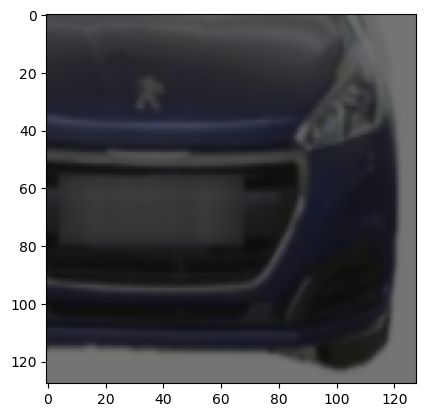

In [13]:
img_size=128

transform = transforms.Compose([
      transforms.RandomApply([transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8)], p=0.8),
      transforms.RandomGrayscale(p=0.2),
      transforms.RandomApply([transforms.GaussianBlur(kernel_size=29, sigma=(0.1, 2.0))],p=0.5),
      transforms.RandomResizedCrop(size=(img_size,img_size), scale=(0.2, 1.0), ratio=(0.75, 1.3333333333333333)),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.Resize(size=(img_size,img_size)),
      transforms.Lambda(lambda x : x.float())
    ])

im = train_images[3]
im_t = transform(im)
_ = plt.imshow(im_t.permute(1,2,0))

# New Physical Features

## Adding missing values to physical table

In [ ]:
# Fill using other values
physical_df_orig = pd.read_csv(join(TABLES,'Ad_table (extra).csv'))
physical_df_orig.rename(columns={' Genmodel_ID':'Genmodel_ID', ' Genmodel':'Genmodel'}, inplace=True)

# Manual touches

# Peugeot RCZ
physical_df_orig.loc[physical_df_orig['Genmodel_ID'] == '69_36','Wheelbase']=2612
# Ford Grand C-Max
physical_df_orig.loc[physical_df_orig['Genmodel_ID'] == '29_20','Wheelbase']=2788 

def fill_from_other_entry(row):
    for attr in ['Wheelbase', 'Length', 'Width', 'Height']:
        if pd.isna(row[attr]) or row[attr]==0:
            other_rows = physical_df_orig.loc[physical_df_orig['Genmodel_ID']==row['Genmodel_ID']]
            other_rows.dropna(subset=[attr], inplace=True)
            other_rows.drop_duplicates(subset=[attr], inplace=True)
            other_rows = other_rows[other_rows[attr]>0]
            if len(other_rows)>0:
                row[attr] = other_rows[attr].values[0]
    return row

physical_df_orig = physical_df_orig.apply(fill_from_other_entry, axis=1)

physical_df_orig.to_csv(join(TABLES,'Ad_table_physical_filled.csv'), index=False)

## Add physical attributes to features

In [ ]:
# Add jitter to physical dimensions so they aren't just labels
def add_jitter(x, jitter=50):
    return x + random.randint(-jitter, jitter)

random.seed(2022)
physical_df = pd.read_csv(join(TABLES,'Ad_table_physical_filled.csv'))
for attr in ['Wheelbase', 'Length', 'Width', 'Height']:
    physical_df[attr] = physical_df[attr].apply(add_jitter)
physical_df.to_csv(join(TABLES,'Ad_table_physical_filled_jittered_50.csv'), index=False)

In [ ]:
# Ford ranger (29_30) has wrong height. Missing 1 in front... 805.0 instead of 1805.0
# Mercedes Benz (59_29) wrong wheelbase, 5246.0 instead of 3106
# Kia Rio (43_9) wrong wheelbase, 4065.0 instead of 2580
# FIXED


physical_df = pd.read_csv(join(TABLES,'Ad_table_physical_filled_jittered_50.csv'))[['Adv_ID', 'Wheelbase','Height','Width','Length']]
# TODO k=['', '_0.1', '_0.01'], change k to generate training datasets with different amounts of low data
k = '_0.01' 
for v in ['_all_views']:
    for split in ['train']:  #, ,'val', 'test'
        features_df = pd.read_csv(join(FEATURES,f'dvm_full_features_{split}_noOH{v}{k}.csv'))
        merged_df = features_df.merge(physical_df, on='Adv_ID')
        physical_only_df = merged_df[['Wheelbase','Height','Width','Length','Bodytype']]

        for attr in ['Wheelbase','Height','Width','Length']:
            assert merged_df[attr].isna().sum()==0
            assert (merged_df[attr]==0).sum()==0

        # normalize physical attributes
        for attr in ['Wheelbase','Height','Width','Length']:
            merged_df[attr] = (merged_df[attr]-merged_df[attr].mean())/merged_df[attr].std()
            physical_only_df[attr] = (physical_only_df[attr]-physical_only_df[attr].mean())/physical_only_df[attr].std()

        # Drop unwanted cols
        non_feature_columns = ['Adv_ID', 'Image_name', 'Genmodel_ID']
        if v == '_all_views':
            non_feature_columns.append('Predicted_viewpoint')
        merged_df = merged_df.drop(non_feature_columns, axis=1)

        merged_df_cols = merged_df.columns.tolist()
        rearranged_cols = merged_df_cols[-4:]+merged_df_cols[:-4]
        merged_df = merged_df[rearranged_cols]
        check_or_save(merged_df, join(FEATURES,f'dvm_features_{split}_noOH{v}{k}_physical_jittered_50.csv'), index=False, header=False)
        check_or_save(physical_only_df, join(FEATURES,f'dvm_features_{split}_noOH{v}{k}_physical_only_jittered_50.csv'), index=False, header=False)
    lengths = torch.load(join(FEATURES,f'tabular_lengths{v}.pt'))
    new_lengths = [1,1,1,1]
    lengths = new_lengths + lengths
    check_or_save(lengths, join(FEATURES,f'tabular_lengths{v}_physical.pt'))
    lengths = [1,1,1,1,13]
    check_or_save(lengths, join(FEATURES,f'tabular_lengths{v}_physical_only.pt'))
print(merged_df.columns)

Index(['Wheelbase', 'Height', 'Width', 'Length', 'Adv_year', 'Adv_month',
       'Reg_year', 'Runned_Miles', 'Price', 'Seat_num', 'Door_num',
       'Entry_price', 'Engine_size', 'Color', 'Bodytype', 'Gearbox',
       'Fuel_type'],
      dtype='object')


/tmp/ipykernel_3450711/4136848522.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  physical_only_df[attr] = (physical_only_df[attr]-physical_only_df[attr].mean())/physical_only_df[attr].std()


In [9]:
# reorder features to categorical, numerical
for v in ['_all_views']:
    field_lengths_tabular = torch.load(join(FEATURES, f'tabular_lengths{v}_physical.pt'))
    categorical_ids = []
    continous_ids = []
    for i in range(len(field_lengths_tabular)):
        if field_lengths_tabular[i] == 1:
            continous_ids.append(i)
        else:
            categorical_ids.append(i)
    print('Categorical Index: {}, '.format(len(categorical_ids)), categorical_ids)
    print('Numerical Index: {}, '.format(len(continous_ids)), continous_ids)

    reorder_ids = categorical_ids + continous_ids
    reorder_field_lengths_tabular = [field_lengths_tabular[i] for i in reorder_ids]
    check_or_save(reorder_field_lengths_tabular, join(FEATURES, f'tabular_lengths{v}_physical_reordered.pt'),)
    for split in ['train', 'val', 'test']:
        data_tabular = pd.read_csv(join(FEATURES, f'dvm_features_{split}_noOH{v}_physical_jittered_50.csv'), header=None)
        reorder_data_tabular = data_tabular.iloc[:, reorder_ids]
        check_or_save(reorder_data_tabular, join(FEATURES, f'dvm_features_{split}_noOH{v}_physical_jittered_50_reordered.csv'), index=False, header=False)
    for k in ['_0.1', '_0.01']:
        data_tabular = pd.read_csv(join(FEATURES, f'dvm_features_train_noOH{v}{k}_physical_jittered_50.csv'), header=None)
        reorder_data_tabular = data_tabular.iloc[:, reorder_ids]
        check_or_save(reorder_data_tabular, join(FEATURES, f'dvm_features_train_noOH{v}{k}_physical_jittered_50_reordered.csv'), index=False, header=False)


Categorical Index: 4,  [13, 14, 15, 16]
Numerical Index: 13,  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


# Add Labels to Featues

In [24]:
for v in ['_all_views']:
    for split in ['train', 'val']:
        labels = torch.load(join(FEATURES,f'labels_model_all_{split}{v}.pt'))
        features = pd.read_csv(join(FEATURES,f'dvm_features_{split}_noOH{v}_physical_jittered_50.csv'), header=None)
        features['label'] = labels
        check_or_save(features, join(FEATURES,f'dvm_features_{split}_noOH{v}_physical_jittered_50_labeled.csv'), index=False, header=False)
    lengths = torch.load(join(FEATURES,f'tabular_lengths{v}_physical.pt'))
    lengths.append(max(labels)+1)
    check_or_save(lengths, join(FEATURES,f'tabular_lengths{v}_physical_labeled.pt'))

Saving to /home/siyi/data/DVM/features/tabular_lengths_all_views_physical_labeled.pt


In [27]:
print(len(lengths))

18


### Remove Adv year

In [22]:
tabular_lengths = torch.load(join(FEATURES, f'tabular_lengths_all_views_physical_reordered.pt'))
print(tabular_lengths)
tabular_lengths = tabular_lengths[:-1]
print(len(tabular_lengths))
check_or_save(tabular_lengths, join(FEATURES, f'tabular_lengths_all_views_physical_reordered_rmAY.pt'))

[22, 13, 3, 12, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
16
Saving to /bigdata/siyi/data/DVM/features/tabular_lengths_all_views_physical_reordered_rmAY.pt


In [19]:
reordered_column_name = [ 'Color', 'Bodytype', 'Gearbox','Fuel_type' ,
               'Wheelbase', 'Height', 'Width', 'Length', 'Adv_year', 'Adv_month',
       'Reg_year', 'Runned_Miles', 'Price', 'Seat_num', 'Door_num',
       'Entry_price', 'Engine_size',]
column_name = ['Wheelbase', 'Height', 'Width', 'Length', 'Adv_year', 'Adv_month',
       'Reg_year', 'Runned_Miles', 'Price', 'Seat_num', 'Door_num',
       'Entry_price', 'Engine_size','Color', 'Bodytype', 'Gearbox','Fuel_type']
for v in ['', '_0.1', '_0.01']:
    for split in ['train']:  # 'train', 'val', 'test'
        reordered_features = pd.read_csv(join(FEATURES,f'dvm_features_{split}_noOH_all_views{v}_physical_jittered_50_reordered.csv'), header=None)
        reordered_features.columns = reordered_column_name 
        reordered_features.drop(['Adv_year'], axis=1, inplace=True)
        check_or_save(reordered_features, join(FEATURES, f'dvm_features_{split}_noOH_all_views{v}_physical_jittered_50_reordered_rmAY.csv'), index=False, header=False)
        break
    break

In [14]:
reordered_features

,Color,Bodytype,Gearbox,Fuel_type,Wheelbase,Height,Width,Length,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,Door_num,Entry_price,Engine_size
0,18,2,1,8,-0.178373,-0.922669,-0.665745,0.066383,1.092766,-1.437819,0.996087,-0.554010,-1.059812,-2.402588,-0.093725,0.147646
1,18,5,1,8,-1.918262,-0.387988,-1.914649,-1.875803,-0.830929,-0.743407,0.247769,-0.500332,-1.059812,-1.395615,-0.704885,-0.889086
2,2,5,1,1,-0.459000,-0.009598,0.158274,-0.532699,-0.830929,0.876887,-0.862641,-0.122699,0.135216,0.618330,-0.435465,-0.370720
3,8,7,1,1,1.443651,2.104451,0.274151,1.206572,0.130919,0.645417,-1.159630,0.309097,2.525272,0.618330,0.223179,0.147646
4,1,10,0,1,0.534420,1.503962,1.748372,0.805573,-1.311853,-0.511936,1.031164,-0.165857,0.135216,0.618330,0.295115,0.666012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70560,18,5,1,8,-0.632989,-0.091856,1.059544,-0.781512,-0.350005,-1.437819,1.417016,-0.643023,0.135216,-1.395615,-0.740990,-0.889086
70561,20,10,1,1,-0.459000,0.673150,-0.717247,-0.452983,-0.350005,0.413946,0.080917,-0.257298,0.135216,0.618330,-0.380487,-0.500312
70562,2,10,0,1,0.775759,0.755408,1.568118,0.730688,1.092766,-0.048995,-0.453779,0.295664,0.135216,0.618330,0.361308,0.147646
70563,2,10,0,1,1.196700,2.746068,1.909314,1.423981,0.611842,-2.363701,1.183166,-0.446384,0.135216,0.618330,0.980291,1.443561
